*** Work in Progress ***

In [1]:
import pandas as pd
import json
from collections import Counter  
from matplotlib import pyplot as plt
import re
import csv
from neo4j import GraphDatabase
from fuzzywuzzy import process,fuzz
from Modules.Pubmed_Import import search_and_dump

In [ ]:
# TODO

# Retrieve Data

### Queries

In [2]:
# Searches for all items with "medical device(s)" in the title or abstract
search_and_dump(query_string='''(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) 
                                AND (("1850"[Date - Publication] : "2004"[Date - Publication]))''',
               max_results=3000, file_name="device_pubmed_data.json", create_json=True)

Search Completed. File dumped to JSON


In [19]:
search_and_dump(query_string='''("Biomedical Technology"[Mesh] OR "Biomedical Engineering"[Mesh]) 
                                AND (1900:2004[pdat]) AND (english[Language])''',
               max_results=10000, file_name="biomed_pubmed_data.json", create_json=True)

Search Completed. File dumped to JSON


# Publication Analysis

Some articles are listed with abnormal years (e.g. years outside of the range that was input to the query). This is a problem that seems to exists even in the browser version of PubMed. These errors are not randomly distributed. They overwhelmingly happen in the final year of the search range. My current solution is to extend the search range beyond what I want (up to the year 2000), then discarding all values outside of my target date range. This should pick up most of the incorrectly labeled data.

In [3]:
def create_df(file_path, cutoff_year=2000):
    with open(file_path, "r") as f:
        full_dict = json.load(f)
    
    slim_dict = {key:value for (key, value) in full_dict.items() if key in ["Pubmed ID", "Title", "Journal", "Date"]}
    df = pd.DataFrame.from_dict(slim_dict)
    # df = df[df["Pubmed ID"] != "000"]  # Removes data with parsing error
    df["Date"] = df["Date"].apply(lambda x : eval(x).year)  # Converts date from __repr__ format
    
    # Cleaning years
    for index in df.loc[df["Date"] > cutoff_year].index:
        df.drop([index], inplace=True)
    
    return df

In [5]:
device_df = create_df("./JSON Data/device_pubmed_data.json", 2000)
device_df.tail(10)

,Pubmed ID,Title,Journal,Date
2810,5244421,H.R. 10726-the Medical Device Safety Act of 1967.,Transactions of the New York Academy of Sciences,1968
2811,000,Criterion for normalizing reliability and repa...,Biomedical engineering,1968
2812,6045459,Special problems in the sterility testing of d...,Bulletin of the Parenteral Drug Association,1967
2813,5260826,A look at medical devices.,Proceedings of the Rudolf Virchow Medical Soci...,1965
2814,14154417,QUACKERY IN THE MEDICAL DEVICE FIELD.,Physical therapy,1964
2815,18017893,Fake Medical Devices: A Health Hazard.,American journal of public health and the nati...,1962
2816,13382425,Fifty years of Food and Drug Administration pr...,Archives of physical medicine and rehabilitation,1957
2817,13323232,Drugs and medical devices.,"Public health reports (Washington, D.C. : 1896)",1956
2818,13234892,Devices and delusions; the physician looks at ...,The Medical annals of the District of Columbia,1955
2819,14924805,Federal control of medical devices.,Archives of physical medicine and rehabilitation,1952


In [4]:
biomed_df = create_df("./JSON Data/biomed_pubmed_data.json", 2000)
biomed_df.tail(10)

,Pubmed ID,Title,Journal,Date
8153,14796813,Educational requirements of the medical techno...,The New England journal of medicine,1951
8154,14796812,The problem of the medical laboratory technolo...,The New England journal of medicine,1951
8155,14901318,A still for continuous fractionation.,Texas reports on biology and medicine,1951
8156,14900972,A simple pipetting device for the reiterated d...,Scandinavian journal of clinical and laborator...,1951
8157,14879029,The quantitative approach to hospital biochemi...,British medical bulletin,1951
8158,14879022,Measurement in medicine; introduction.,British medical bulletin,1951
8159,14810717,Medical technology in research.,The American journal of medical technology,1951
8160,15421650,Room for improvement in M.T. training.,Hospital progress,1950
8161,15415233,Twenty-ninth annual presentation of hospital d...,Journal of the American Medical Association,1950
8162,15402177,Recruitment of medical technologists.,The American journal of medical technology,1950


### Publications by Year

In [9]:
device_date_group = device_df.groupby(["Date"])
device_pub_year_table = device_date_group["Journal"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))

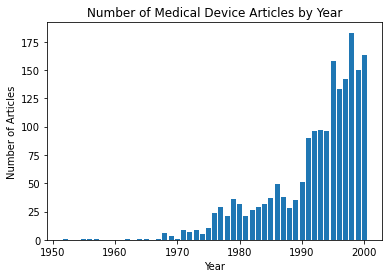

In [11]:
plt.bar(device_pub_year_table.index, [device_pub_year_table.get(x) for x in device_pub_year_table.index])
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.title("Number of Medical Device Articles by Year")
plt.show()

In [5]:
biomed_date_group = biomed_df.groupby(["Date"])
biomed_pub_year_table = biomed_date_group["Journal"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))

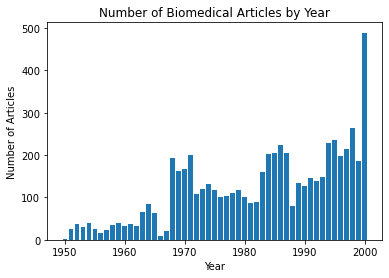

In [7]:
plt.bar(biomed_pub_year_table.index, [biomed_pub_year_table.get(x) for x in biomed_pub_year_table.index])
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.title("Number of Biomedical Articles by Year")
plt.show()

### For Export to Voyant Tools

In [5]:
def voyant_export(year_group, dataset_name, start_year, end_year=2000):
    year_title_list = year_group["Title"].unique()
    
    for year in range(start_year, end_year + 1):
        temp_list = []
        try:
            for title in year_title_list[year]:
                title = title.replace("--", " ")
                title = title + "\n"
                temp_list.append(title)
            
            with open("Title Data Files/{a}/{b}_{a}.txt".format(b=year, a=dataset_name), "w") as f:
                f.writelines(temp_list)
       
        except KeyError:  # If there were no publication in a year in the range
            pass
    
    print("Data Exported")

In [ ]:
voyant_export(year_group = device_date_group, dataset_name="med_dev", start_year=1952, end_year=2000)

Medical Device Publication Word Frequency: https://voyant-tools.org/?corpus=fa33b04ff82a6bb8eb2bb7c2b5c9837a&panels=corpusterms,termsberry,trends,summary,contexts

In [10]:
voyant_export(year_group = biomed_date_group, dataset_name="biomed", start_year=1950, end_year=2000)

Data Exported


Biomedical Publication Corpus: https://voyant-tools.org/?corpus=d27c6e29211b43ce02d1d96f182704ae

# Network Analysis in Neo4J

In [25]:
# Create author info json file
def get_author_info(pubmed_data, cutoff_year, write_file):
    identifier_list = {}
    id_count = 1
    
    # Create data structure for author
    for i, paper in enumerate(pubmed_data["Authors"]):
        for author in paper:
            if author["name"] != None and eval(pubmed_data["Date"][i]).year <= cutoff_year:
                
                # If author is already in the dictionary
                if author["name"].lower() in identifier_list.keys():

                    # Update Values
                    identifier_list[author["name"].lower()]["weight"] += 1
                    identifier_list[author["name"].lower()]["years active"].append(pubmed_data["Date"][i])      

                # If the author is not already in the dictionary
                else:
                    identifier_list[author["name"].lower()]  = {"id": id_count, 
                                                        "years active":[pubmed_data["Date"][i]], 
                                                        "affiliation":[], "weight": 1, "edges":[]}

                # Get year/affiliation data for GIS
                if author["affiliation"] != None:
                    aff = author["affiliation"]
                    aff = re.sub(r"[^@ \t\r\n]+@[^@ \t\r\n]+\.[^@ \t\r\n]+", "", aff)  # Remove emails. Some authors only list email.
                    aff = re.sub(r"(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()!@:%_\+.~#?&\/\/=]*)", "", aff)  # Remove websites
                    aff = aff.strip(" ")
                    if aff != "":  # Skips authors who only put an email as thier insitution
                        identifier_list[author["name"].lower()]["affiliation"].append((aff, pubmed_data["Date"][i]))

                # Append other authors to edges list
                temp_list = [(o_author["name"].lower(), pubmed_data["Date"][i]) for o_author in paper]  # Co-author name and year of collaboration
                for item in temp_list:
                    if item[0] != author["name"].lower():
                        identifier_list[author["name"].lower()]["edges"].append(item) 

                id_count +=1
            
    with open(write_file, "w") as f:
        json.dump(identifier_list, f, indent=4)

In [3]:
# Clean author insitituitonal affiliations using fuzzy matching
def match_affiliation(author_data, min_ratio, filename):
    full_list = [] 
    for author in author_data: # Extract all listed institutions
        for item in author_data[author]["affiliation"]:
            full_list.append(item[0])

    full_list = (set(full_list)) # Get unique items 
    reducing_list = full_list.copy()
    already_categorized = []
    similarity_groups = []

    for insitituiton in full_list:
        if insitituiton not in already_categorized:
            group = [insitituiton]
            already_categorized.append(insitituiton)
            ratios = process.extract(insitituiton, reducing_list, scorer=fuzz.token_sort_ratio)  # Can tweek the scorer used
            for inst_ratio in ratios:
                if inst_ratio[0] != insitituiton and inst_ratio[1] > min_ratio:
                    group.append(inst_ratio[0])
                    already_categorized.append(inst_ratio[0])
                    reducing_list.remove(inst_ratio[0])
            similarity_groups.append(group)
    
    # Save groups to JSON
    group_dict_by_id = {i:keys for i,keys in enumerate(similarity_groups)}
    with open(filename, "w") as f:
        json.dump(group_dict_by_id, f, indent=4)
    print("Groups Saved")


In [6]:
# Medical Devices
# Create author data file
with open("JSON Data/device_pubmed_data.json", "r") as f:
    pubmed_data = json.load(f)
get_author_info(pubmed_data=pubmed_data, write_file="JSON Data/device_author_data.json")

# Extract and clean affiliations
with open("JSON Data/device_author_data.json", "r") as f:
    data = json.load(f)
match_affiliation(data, 90, "JSON Data/device_institution_match.json")

In [26]:
# Biomedical
with open("JSON Data/biomed_pubmed_data.json", "r") as f:
    pubmed_data = json.load(f)
get_author_info(pubmed_data=pubmed_data, cutoff_year=2000, write_file="JSON Data/biomed_author_data.json")

with open("JSON Data/biomed_author_data.json", "r") as f:
    data = json.load(f)
match_affiliation(data, 90, "JSON Data/biomed_institution_match.json")

### Fuzzy Matching Testing

In [10]:
fuzz.token_sort_ratio(
    'Department of Anesthesiology, University of Washington School of Medicine and the Virginia Mason Medical Center, Seattle 98111-0900, USA.',
     'University of Virginia, USA.')

33

In [3]:
fuzz.token_set_ratio(
    "Center for Devices and Radiological Health, Food and Drug Administration, Rockville, MD 20857.",
    "Center for Devices and Radiological Health Food and Drug Administration.")

100

In [12]:
fuzz.token_set_ratio(
    "Kluyver Laboratory for Biotechnology, Delft University of Technology, Delft, The Netherlands.",
    "Kluyverlaboratory for Biotechnology, Technical University Delft, Delft, The Netherlands.")

93

## Neo4J

In [27]:
# Pick the correct driver for target local database
#driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "devices"))
driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "biomed"))

In [28]:
def create_author_node(tx, author_name, author_data):
        tx.run("MERGE (a: author {id: $id, name: $name, years_active: $years_active})", 
        id=author_data[author_name]["id"], name=author_name, 
        # Some authors have multiple papers published in the same year. Ex: Munzner RF
        years_active=list(set([eval(date).year for date in author_data[author_name]["years active"]])))

In [29]:
def add_relationships(tx, author_name, author_data):
    for coauthor in author_data[author_name]["edges"]:
        tx.run("""MATCH (a: author {id: $a_id, name: $a_name})
        MATCH (b: author {id: $b_id, name: $b_name})
        MERGE (a)-[c:COAUTHOR {date: $date}]->(b)""",
        a_id=author_data[author_name]["id"],
        a_name=author_name,
        b_id=author_data[coauthor[0]]["id"],
        b_name=coauthor[0],
        date=eval(coauthor[1]).isoformat())


In [30]:
def create_institutions_node(tx, group_id, institution_data):
    tx.run("MERGE (i: institution {id: $id, first_name:$first_name, all_names: $all_names})", 
    id=group_id, first_name=institution_data[group_id][0], 
    all_names=[name+"|" for name in institution_data[group_id]])  # | To help make separation between names more clear in Neo4j

In [31]:
def add_institution_relationships(tx, author_name, author_data, institution_data, group_dict_by_name): 
    # Make list of dates author was affiliated with location
    dates_dict = {}
    for institution in author_data[author_name]["affiliation"]:
        try:
            dates_dict[group_dict_by_name[institution[0]]].append(institution[1])
        except:
            dates_dict[group_dict_by_name[institution[0]]] = [institution[1]]

    # Execute CYPHER
    for item in dates_dict.keys():
        tx.run("""MATCH (a: author {id: $a_id, name: $a_name})
        MATCH (b: institution {id: $i_id})
        MERGE (a)<-[c:AFFILIATED {dates: $dates}]-(b)""",
        a_id=author_data[author_name]["id"],
        a_name=author_name,
        i_id=item,
        dates=[eval(date).isoformat() for date in dates_dict[item]])
        

In [32]:
with open("JSON Data/biomed_author_data.json", "r") as f:
        author_data = json.load(f)

with open("JSON Data/biomed_institution_match.json", "r") as f:
    institution_data = json.load(f)

with driver.session() as session:
    for author_name in author_data.keys():
        session.write_transaction(create_author_node, author_name, author_data)

with driver.session() as session:
    for author_name in author_data.keys():
        session.write_transaction(add_relationships, author_name, author_data)

with driver.session() as session:
    for group_id in institution_data.keys():
        session.write_transaction(create_institutions_node, group_id, institution_data)

#Add insitution relationships
with driver.session() as session:
    # Create reference dict
    group_dict_by_name = {} 
    for k,v in institution_data.items():
        for name in v:
            group_dict_by_name[name] = k
    
    # Execute CYPHER
    for author_name in author_data.keys():
        session.write_transaction(add_institution_relationships, 
        author_name, author_data, institution_data, group_dict_by_name)